# Smart Cities, Lab 1: Digital Equity Plans 
INFO 5455, Cornell Tech, Prof. Anthony Townsend. Developed by Matt Franchi (@mattwfranchi).


In this lab, we review the 2021 Digital Equity Plan of the US city of Philadelphia, Pennsylvania, and use empirical datasets from the [American Community Survey](https://www.census.gov/programs-surveys/acs) to explore the themes and goals of the report. 

## 0. Module Imports
To run the below cell, you will need to have the listed packages installed. I will provide pip install commands for the case of using Google Colab. 

In [99]:
!pip install pandas geopandas matplotlib

In [100]:
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt 
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import os
import sys 
sys.path.append("../../utils")
from logger import setup_logger
from acs import parse_md, parse_acs, get_acs_data, get_acs_data_range
# set up logging
logger = setup_logger("lab1-DEPs")
logger.setLevel("INFO")

logger.success("Setup complete.")


2025-01-28 17:06:46 - lab1-DEPs - SUCCESS - Setup complete.


## 1. Loading Data 
Prior to running these cells, you should have pulled all data via the scripts in pull/. 

In [101]:
# the first year of ACS data that you want to load 
ACS_YEAR_START = 2022
# the last year of ACS data that you want to load
ACS_YEAR_END = 2022

logger.info(f"Will load ACS datasets from {ACS_YEAR_START} to {ACS_YEAR_END}.")

2025-01-28 17:06:46 - lab1-DEPs - INFO - Will load ACS datasets from 2022 to 2022.


In [102]:
ct_nyc = gpd.read_file('data/ct-nyc-2020.geojson')

In [103]:
# American Community Survey (ACS) data
DATASETS = {
    'dp05': 'Housing and Demographic Estimates',
    's2801': 'Types of Computers and Internet Subscriptions',
    's1501': 'Education Attainment',
    's1901': 'Income',
    's1602': 'Language Spoken at Home',
}

In [104]:
PARSE_MD = True 
os.makedirs('data/dictionaries', exist_ok=True)
if PARSE_MD:
    # parse and write the md for each dataset 
    for dataset in DATASETS.keys():
        md = pd.read_json(f'data/acs{ACS_YEAR_START}_{dataset}_md.json')
        md = parse_md(md)
        md.to_csv(f'data/dictionaries/acs_{dataset}_md.csv', index=False)

Found 730 columns in the dataset
Found 250 columns in the dataset
Found 1538 columns in the dataset
Found 258 columns in the dataset
Found 82 columns in the dataset


In [105]:
# you can add columns and corresponding human-readable names here as needed.
RACE_COLS = {
    'DP05_0001E': 'total_population',
    'DP05_0079E': 'nhl_white_alone', 
    'DP05_0080E': 'nhl_black_alone', 
    'DP05_0073E': 'hispanic_alone', 
    'DP05_0082E': 'nhl_asian_alone'
}

INTERNET_ACCESS_COLS = { 
    'S2801_C01_012E': 'num_households_with_internet',
    'S2801_C01_005E': 'num_households_with_smartphone'
}

INCOME_COLS = {
    'S1901_C01_012E': 'median_household_income'
}

EDUCATION_COLS = {
    'S1501_C01_009E': 'num_high_school_graduates',
    'S1501_C01_012E': 'num_bachelors_degree',
    'S1501_C01_013E': 'num_graduate_degree'
}

LEH_COLS = {
    'S1602_C03_001E': 'num_limited_english_speaking_households'
}

In [106]:
# dp05: demographic and housing estimates 
dp05 = get_acs_data_range(ACS_YEAR_START, ACS_YEAR_END, 'dp05', RACE_COLS)

In [107]:
# s2801: types of computers and internet subscriptions
s2801 = get_acs_data_range(ACS_YEAR_START, ACS_YEAR_END, 's2801', INTERNET_ACCESS_COLS) 

In [108]:
# s1901: income in the past 12 months
s1901 = get_acs_data_range(ACS_YEAR_START, ACS_YEAR_END, 's1901', INCOME_COLS)

In [109]:
# s1501: educational attainment
s1501 = get_acs_data_range(ACS_YEAR_START, ACS_YEAR_END, 's1501', EDUCATION_COLS)

In [110]:
# s1602: language spoken at home
s1602 = get_acs_data_range(ACS_YEAR_START, ACS_YEAR_END, 's1602', LEH_COLS)

In [111]:
s1602

,num_limited_english_speaking_households,year
tract_id,,
36005000100,0,2022
36005000200,257,2022
36005000400,445,2022
36005001600,336,2022
36005001901,55,2022
...,...,...
36085030302,86,2022
36085031901,46,2022
36085031902,87,2022


## 2. Unifying Data 

In [112]:
# merge all acs datasets into ct_nyc. 
# this is a bit messy, ideally we would condense the temporal dimension so that there is only one row per census tract. 
# we leave it in this format for now to make a wider variety of analyses more easily doable.
ct_nyc = ct_nyc.merge(dp05, left_on='GEOID', right_on='tract_id', how='right', suffixes=('', '_dp05'))
ct_nyc = ct_nyc.merge(s2801, left_on='GEOID', right_on='tract_id', how='right', suffixes=('', '_s2801'))
ct_nyc = ct_nyc.merge(s1901, left_on='GEOID', right_on='tract_id', how='right', suffixes=('', '_s1901'))
ct_nyc = ct_nyc.merge(s1501, left_on='GEOID', right_on='tract_id', how='right', suffixes=('', '_s1501'))
ct_nyc = ct_nyc.merge(s1602, left_on='GEOID', right_on='tract_id', how='right', suffixes=('', '_s1602'))

In [116]:
ct_nyc['median_household_income'].describe()

count    2.325000e+03
mean    -3.547490e+07
std      1.498496e+08
min     -6.666667e+08
25%      5.330100e+04
50%      7.683300e+04
75%      1.023750e+05
max      2.500010e+05
Name: median_household_income, dtype: float64

## 3. Sample Plots 

(-74.28337200223557, -73.67223129208493, 40.475172248852914, 40.93651102004259)

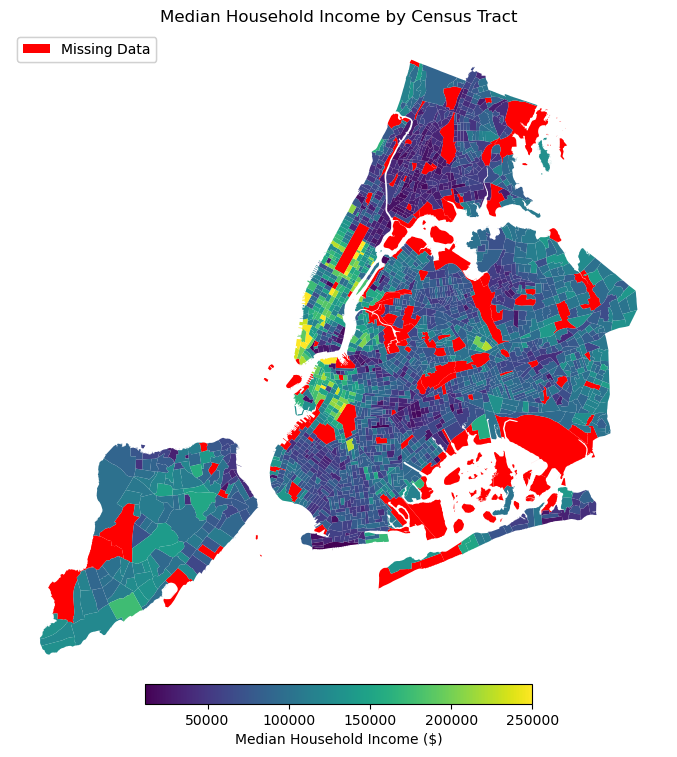

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot missing data
ct_nyc[ct_nyc['median_household_income'] < 0].plot(
    ax=ax, 
    color='red'
)

# Plot valid data with colorbar
ct_nyc[ct_nyc['median_household_income'] > 0].plot(
    column='median_household_income', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': 'Median Household Income ($)', 'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.0}
)

# Create and add custom legend for missing data
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Missing Data')
]

# Create a separate legend for the missing data indicator
legend2 = ax.legend(handles=legend_elements, loc='upper left')

# Add this legend as a second artist
ax.add_artist(legend2)

plt.title('Median Household Income by Census Tract')

ax.axis('off')